In [3]:
torch.cuda.set_device(0)

In [ ]:
## Treat larger sequence 

In [2]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

In [5]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

In [6]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

mu, sigma = traindf.Return.mean(), traindf.Return.std()

trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=mu, sigma=sigma)
validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=mu, sigma=sigma)
testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=mu, sigma=sigma)

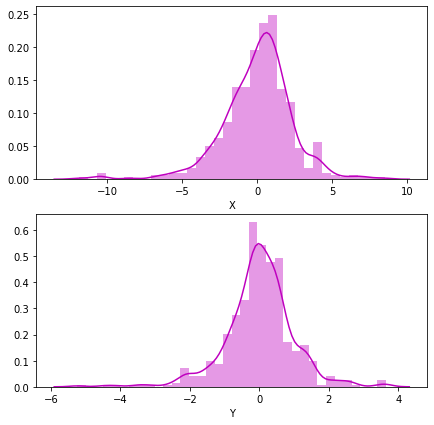

In [7]:
X = []
Y = []
for item in trainloader:
    X.append((torch.sum(item[0])/len(item[0])))
    Y.append(item[1])
normal_df = pd.DataFrame(list(zip(X,Y)), columns= ["X","Y"])

f, axes = plt.subplots(2, 1, figsize=(7, 7))
sns.distplot(normal_df["X"], color="m", ax =axes[0])
sns.distplot(normal_df["Y"], color="m", ax= axes[1])

In [24]:
import torch.nn as nn 

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=70, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, dropout=0.25 )

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

LSTM(
  (lstm): LSTM(1, 70, dropout=0.25)
  (linear): Linear(in_features=70, out_features=1, bias=True)
)

In [ ]:
epochs = 500
loss = []
for i in range(epochs):
    for seq, labels in trainloader:
        optimizer.zero_grad()

        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq.squeeze())

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        loss.append(single_loss.item())
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 1.15359068
epoch:  26 loss: 1.40931499


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU, PT_test


valid_targets = []
valid_preds = []
with torch.no_grad():
    for seq, target in testloader:
        valid_preds.append(model(seq.squeeze()))
        valid_targets += target.numpy().tolist()



validRMSE = mean_squared_error(valid_targets, valid_preds)
validMAE = mean_absolute_error(valid_targets, valid_preds)
validMAPE = mean_absolute_percentage_error(np.array(valid_targets), np.array(valid_preds))
validTheilU = theilU(np.array(valid_targets), np.array(valid_preds))

print("Valid MAE : {:.4f} | Valid MAPE  : {:.4f} | Valid RSME : {:.4f} | Valid Theil-U {:.4f}".format(validMAE, validMAPE, validRMSE, validTheilU))
        

Valid MAE : 0.6492 | Valid MAPE  : 8.5539 | Valid RSME : 0.7420 | Valid Theil-U 0.7090


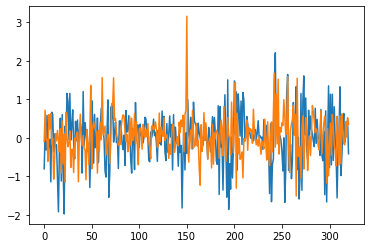

In [19]:
plt.plot(valid_targets)
plt.plot(valid_preds)

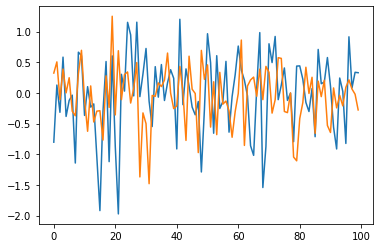

In [32]:
plt.plot(valid_targets[:100])
plt.plot(valid_preds)

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU, PT_test


valid_targets = []
valid_preds = []
with torch.no_grad():
    for seq, target in testloader:
        valid_preds.append(model(seq.squeeze()))
        valid_targets += target.numpy().tolist()



validRMSE = mean_squared_error(valid_targets, valid_preds)
validMAE = mean_absolute_error(valid_targets, valid_preds)
validMAPE = mean_absolute_percentage_error(np.array(valid_targets), np.array(valid_preds))
validTheilU = theilU(np.array(valid_targets), np.array(valid_preds))

print("Valid MAE : {:.4f} | Valid MAPE  : {:.4f} | Valid RSME : {:.4f} | Valid Theil-U {:.4f}".format(validMAE, validMAPE, validRMSE, validTheilU))
        

Valid MAE : 0.6233 | Valid MAPE  : 3.5624 | Valid RSME : 0.6453 | Valid Theil-U 0.7062
